# ============================================
# Module 9b: Foundations of Training & Transformers
# Lab 4 – Exploring a Hugging Face Dataset (TweetEval Sentiment)
# ============================================
**Author:** Dr. Dasha Trofimova

### Learning Goals
- Inspect dataset structure and label schema
- Visualize class balance and token lengths
- Connect EDA to preprocessing choices (max_length, truncation)

---


In [1]:
!pip install datasets transformers matplotlib seaborn --quiet
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid", context="talk")

In [2]:
ds = load_dataset("tweet_eval", "sentiment")
label_names = ds["train"].features["label"].names
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

/tmp/ipython-input-1184861122.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="Set2")


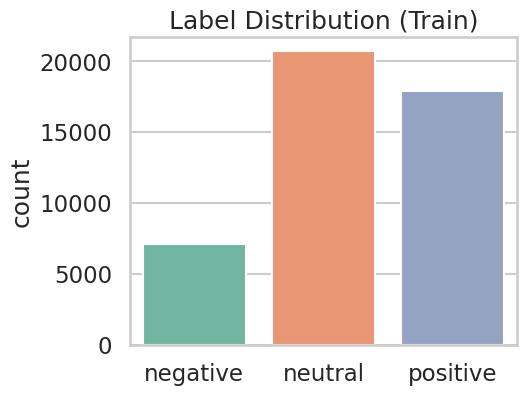

[negative] Businesses closed on Sunday are against my beliefs and affect me but I deal with it. Gay marriage doesn't even affect you so don't be a dick

[neutral] Chess game today... If anyone is in Dumbo today at the Brooklyn Bridge Pier. Come play a game with me.

[positive] Wow my last RT. It\u2019s only been 4 years since Verm\u2019s arrival. He\u2019s now Captain and will make his 100th start for AFC on Sat. Time flies.



In [4]:
train = ds["train"]
labels = [ex["label"] for ex in train]
plt.figure(figsize=(5,4))
sns.countplot(x=labels, palette="Set2")
plt.xticks(range(len(label_names)), label_names)
plt.title("Label Distribution (Train)"); plt.show()
import numpy as np

for i in np.random.choice(len(train), size=3, replace=False):
    i = int(i)  # <- cast to Python int
    print(f"[{label_names[train[i]['label']]}] {train[i]['text']}\n")


len stats → median=30, p75=35, p90=40, p95=43


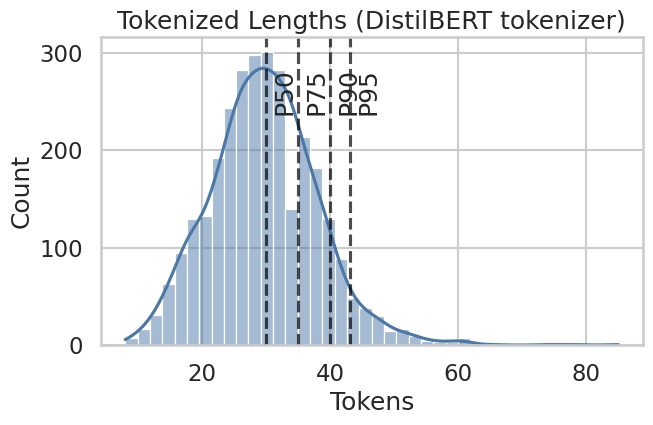

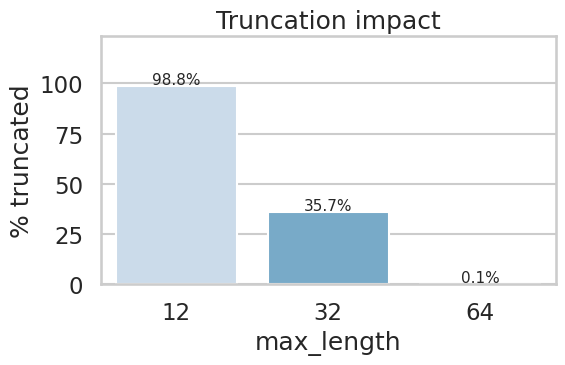

In [6]:
# Token length distribution & truncation plan
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
sample = train.shuffle(seed=42).select(range(3000))
lens = [len(tok(ex["text"], add_special_tokens=True)["input_ids"]) for ex in sample]
lens = np.array(lens)

p50, p75, p90, p95 = np.percentile(lens, [50,75,90,95])
print(f"len stats → median={p50:.0f}, p75={p75:.0f}, p90={p90:.0f}, p95={p95:.0f}")

plt.figure(figsize=(7,4))
sns.histplot(lens, bins=40, kde=True, color="#4C78A8")
for v, lab in [(p50,'P50'), (p75,'P75'), (p90,'P90'), (p95,'P95')]:
    plt.axvline(v, ls='--', c='black', alpha=0.7)
    plt.text(v+1, plt.ylim()[1]*0.9, lab, rotation=90, va='top')
plt.title("Tokenized Lengths (DistilBERT tokenizer)"); plt.xlabel("Tokens"); plt.show()

def trunc_stats(lengths, max_len_list=(64,128,256)):
    total=len(lengths); out=[]
    for m in max_len_list:
        pct = float((lengths>m).sum())*100/total
        out.append((m,pct))
    return out

stats = trunc_stats(lens, (12, 32, 64))
ms = [str(m) for m,_ in stats]; pct = [p for _,p in stats]

plt.figure(figsize=(6,4))
sns.barplot(x=ms, y=pct, hue=ms, palette="Blues", legend=False)  # seaborn>=0.14 safe
for i, v in enumerate(pct):
    plt.text(i, v+1, f"{v:.1f}%", ha="center", fontsize=11)
plt.ylim(0, max(pct)*1.25 if pct else 1)
plt.xlabel("max_length"); plt.ylabel("% truncated")
plt.title("Truncation impact"); plt.tight_layout(); plt.show()

### 🎯 Quick Card Quiz — Dataset & Tokenization

**Color legend:**  
- **Blue = Shorter max_length (e.g., 12)**  
- **Orange = Medium max_length (e.g., 32)**  
- **Green = Longer max_length (e.g., 64)**

1) Which setting will be fastest but risks truncating the most text?
2) If P95 token length is ~30, which max_length is a reasonable trade-off?
3) If label distribution is imbalanced, should we trust accuracy alone?